In [26]:
from scipy.interpolate import BSpline
import numpy as np
from astrosceni.image import Image
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

def calculateSkew(image_data):
  data = np.array(image_data.flatten())
  N = np.sum(~np.isnan(data))
  mean = np.nanmean(data)   # Mean of the data
  std_dev = np.nanstd(data, ddof=1)
  
  # Compute skewness
  return np.nansum(((data - mean) / std_dev) ** 3) / (N - 1)

def getSkews(NB_image, BB_image, scale_factor_linspace):
  skews = []
  for mu in scale_factor_linspace:
    skews.append(calculateSkew(NB_image.getImageData() - mu*BB_image.getImageData()))
  return skews


In [68]:
bb = Image('../data/rim_R_wcs.fits')
nb = Image('../data/rim_Ha_wcs.fits')

nb.cropPixels(x_start=50, x_end=2000, y_start=50, y_end=1350)
bb.cropPixels(x_start=50, x_end=2000, y_start=50, y_end=1350)
scale_factor_linspace = np.linspace(0, 2, 80)

print(np.max(nb.getImageData()))
print(np.max(bb.getImageData()))

IMAGE_DATA (1392, 2080)
COL_MAX 2079
COL_MIN 0
IMAGE_DATA (1392, 2080)
COL_MAX 2079
COL_MIN 0
32767.0
32767.0


In [74]:
bb = Image('../data/rim_R_wcs.fits')
nb = Image('../data/rim_Ha_wcs.fits')

nb.cropPixels(x_start=50, x_end=2000, y_start=50, y_end=1350)
bb.cropPixels(x_start=50, x_end=2000, y_start=50, y_end=1350)
scale_factor_linspace = np.linspace(0, 2, 80)



skews = getSkews(bb, nb, scale_factor_linspace)

# remove saturated pixels
data = nb.getImageData()
data[data > (2**15)-2] = np.nan
nb.setImageData(data)

data = bb.getImageData()
data[data > (2**15)-2] = np.nan
bb.setImageData(data)

skews_nan = getSkews(bb, nb, scale_factor_linspace)

IMAGE_DATA (1392, 2080)
COL_MAX 2079
COL_MIN 0
IMAGE_DATA (1392, 2080)
COL_MAX 2079
COL_MIN 0


In [67]:
np.max(nb.getImageData())
np.max(bb.getImageData())
# np.sum(np.isnan(bb.getImageData()))

np.float32(32767.0)

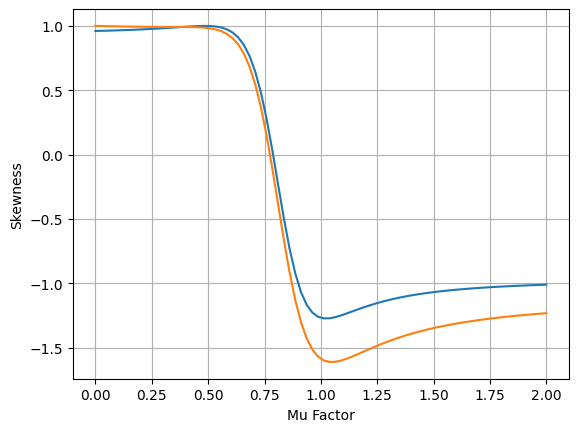

In [75]:
plt.xlabel('Mu Factor')
plt.ylabel('Skewness')
plt.grid()
plt.plot(scale_factor_linspace, skews/np.nanmax(skews))
plt.plot(scale_factor_linspace, skews_nan/np.nanmax(skews_nan))
# plt.ylim(0.95, 1)
# plt.xlim(0.1, 0.6)

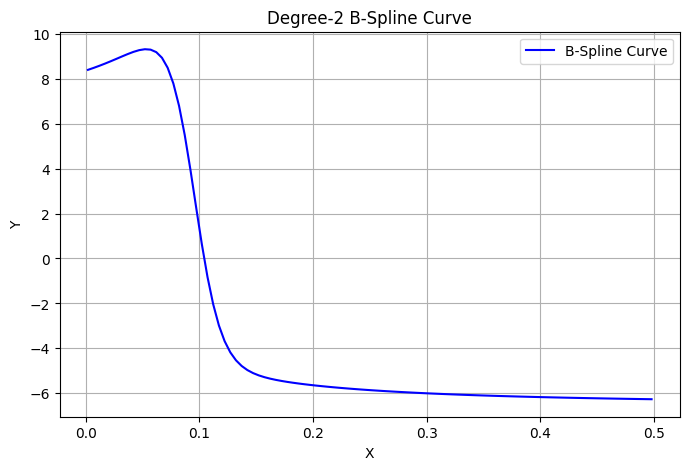

In [5]:
# Define degree of B-Spline
p = 2  # Degree 2


# Extract x and y coordinates
px, py = scale_factor_linspace, skews

# Define a valid knot vector (m = n + p + 1, where n = len(control_points) - 1)
n = len(skews) - 1  # Number of control points - 1
knots = np.linspace(0, 1, n + p + 2)  # Uniformly spaced clamped knot vector

# Define B-Spline basis functions
spline_x = BSpline(knots, px, p)
spline_y = BSpline(knots, py, p)

# Define parameter range for plotting
u = np.linspace(knots[p], knots[-p-1], 100)  # Only valid range

# Compute curve points
curve_x = spline_x(u)
curve_y = spline_y(u)

# Plot B-Spline curve and control polygon
plt.figure(figsize=(8, 5))
# plt.plot(px, py, 'ro--', label="Control Polygon")  # Control points
plt.plot(curve_x, curve_y, 'b-', label="B-Spline Curve")  # B-Spline curve

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Degree-2 B-Spline Curve")
plt.legend()
plt.grid()
plt.show()


In [6]:
from scipy.optimize import fsolve
degree = p
# Compute the first derivative of the y-component
spline_y_derivative = spline_y.derivative()

# Define a function to find roots (dy/du = 0)
def dy_du_zero(u):
    return spline_y_derivative(u)

# Find zeros in the valid range
initial_guesses = np.linspace(knots[degree], knots[-degree-1], 5)  # Initial guesses for roots
roots = fsolve(dy_du_zero, initial_guesses)

# Filter roots to keep only those within the valid u range
valid_roots = [u for u in roots if knots[degree] <= u <= knots[-degree-1]]

# Convert to X coordinates
x_at_zero_slope = spline_x(valid_roots)

# Display the results
valid_roots, x_at_zero_slope

([], array([], dtype=float64))

32758.0


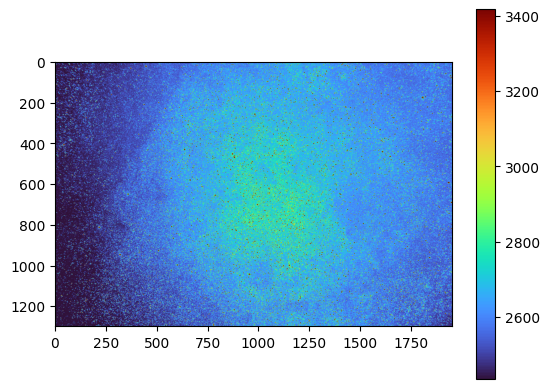

32757.0


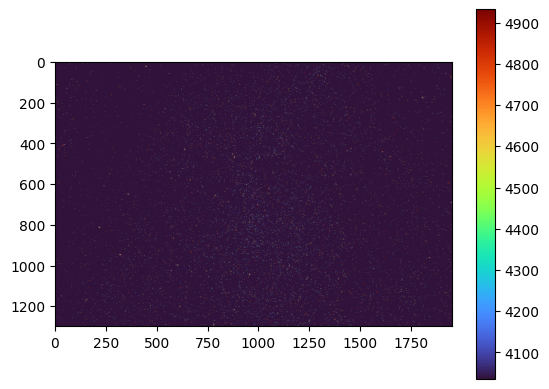

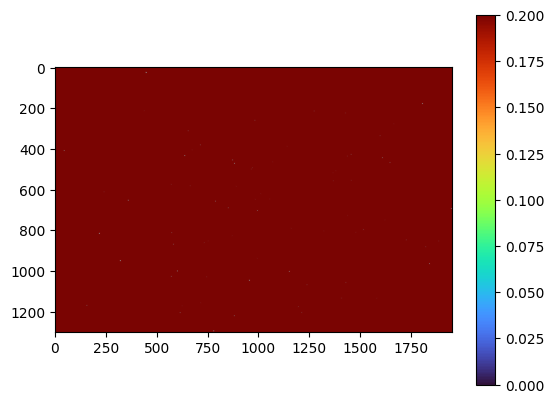

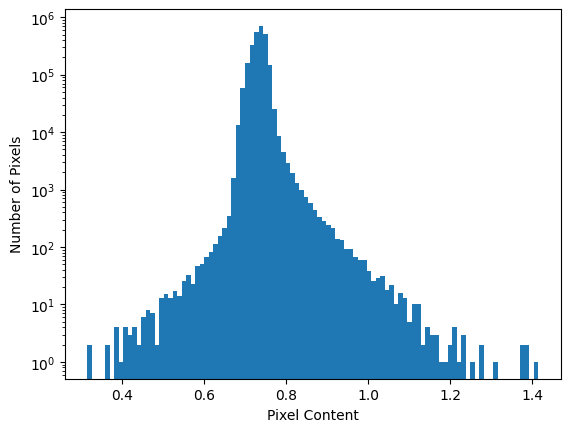

In [76]:
data = bb.getImageData()
print(np.nanmax(data))
vmin=np.nanpercentile(data,  5)
vmax=np.nanpercentile(data,  99)
plt.imshow(data, vmin=vmin, vmax=vmax, cmap='turbo')
plt.colorbar()
plt.show()

data = nb.getImageData()
print(np.nanmax(data))
vmin=np.nanpercentile(data,  5)
vmax=np.nanpercentile(data,  99)
plt.imshow(data, 
        vmin=vmax, vmax=vmax,
        # norm=LogNorm( vmin=vmin, vmax=vmax ),
        cmap='turbo')
plt.colorbar()
plt.show()

data = bb.getImageData()/nb.getImageData()
vmin=0
vmax=0.2
plt.imshow(data, 
           vmin=vmin, vmax=vmax, 
        cmap='turbo')
plt.colorbar()
plt.show()

# flatten means: we put our 2d array in a 1d array
histogram = plt.hist(data.flatten(), 100)

plt.xlabel('Pixel Content')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.show()

27967.8


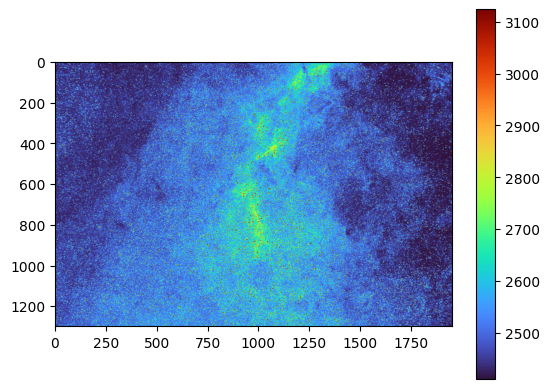

32757.0


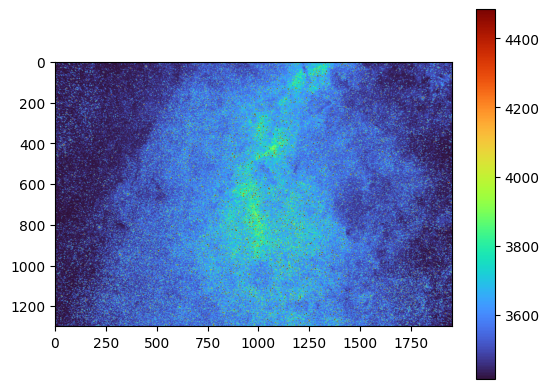

In [77]:

img_mu = 0.4
# img_mu = 0.9
# vmin = np.min(nb.getImageData() - bb.getImageData())
# vmax = np.max(nb.getImageData())
data = nb.getImageData() - img_mu * bb.getImageData()
print(np.nanmax(data))
vmin=np.nanpercentile(data,  5)
vmax=np.nanpercentile(data,  99)
plt.imshow(data, cmap='turbo', 
vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.show()
img_mu = 0
# img_mu = 0.9
# vmin = np.min(nb.getImageData() - bb.getImageData())
# vmax = np.max(nb.getImageData())
data = nb.getImageData() - img_mu * bb.getImageData()
print(np.nanmax(data))
vmin=np.nanpercentile(data,  5)
vmax=np.nanpercentile(data,  99)
plt.imshow(data, cmap='turbo', 
vmin=vmin, vmax=vmax
)
plt.colorbar()

In [73]:
data = bb.getImageData()
print(np.sum(data > (2**15)-20))

data = nb.getImageData()
print(np.sum(data > (2**15)-20))

33
292
